In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.path import Path
from scipy.spatial import Delaunay

from a5utils import bilinear_interpolate
from IPython.display import HTML
from a5utils import display_movie

from scipy.ndimage import gaussian_filter

In [2]:
def get_transform(source_pt, target_pt):
    x = np.ones((3,3))
    y = np.ones((3,3))
    
    x[0:2, :] = source_pt
    y[0:2, :] = target_pt
    
    xt = np.linalg.inv(x)
    T = np.matmul(y, xt)
    T[2, :] = [0,0,1]
    return T

def apply_transform(T, pts):
    
    n = pts.shape[1]
    warp_pt = np.ones((2,n))
    for i in range(n):
        pt = np.ones((3,1))
        pt[0] = pts[0][i]
        pt[1] = pts[1][i]
        pt = np.matmul(T, pt)
        warp_pt[:, i] = pt[:2, 0]
        
    return warp_pt

In [10]:
def warp(img, source_pt, target_pt, tri):
    
    ntri = tri.shape[0]
    h,w,d = image.shape
    
    
    t_index = np.ones((h,w)) * (-1)
    xx, yy = np.mgrid[0:h, 0:w]
    p_coord = np.stack((yy.flatten(), xx.flatten()), axis=1)
    
    for t in range(ntri):
        corners = np.vstack([target_pt[:, tri[t, 0]], target_pt[:, tri[t, 1]], target_pt[:, tri[t, 2]]])  
        triangle = Path(corners)
        mask = np.array([triangle.contains_point(p) for p in p_coord]) 
        mask = mask.reshape(h,w)
        t_index[mask] = t
    
    Xsource = np.zeros((2,h*w)) 
    t_index_flat = t_index.flatten()
    
    for t in range(ntri):
        targ = target_pt[:, tri[t]]
        psrc = source_pt[:, tri[t]]
        T = get_transform(targ,psrc)
        pcoords_t = np.transpose(p_coord[t_index_flat == t])
        Xsource[:,t_index_flat==t] = apply_transform(T,pcoords_t)
        
    warp_image = np.zeros(image.shape)
    warp_image[:,:,0] = bilinear_interpolate(image[:, :, 0], Xsource[0], Xsource[1]).reshape(h,w)
    warp_image[:,:,1] = bilinear_interpolate(image[:, :, 1], Xsource[0], Xsource[1]).reshape(h,w)
    warp_image[:,:,2] = bilinear_interpolate(image[:, :, 2], Xsource[0], Xsource[1]).reshape(h,w)
    warp_image = np.clip(warp_image,0.,1.)

    return (warp_image,t_index)        

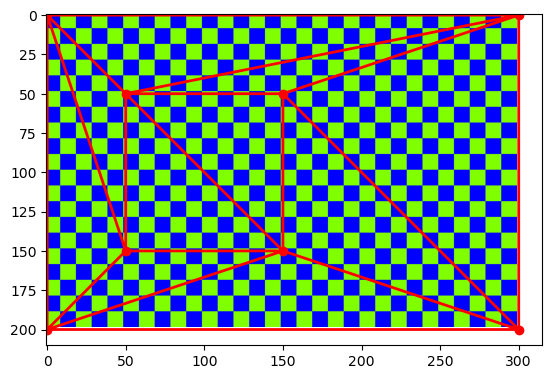

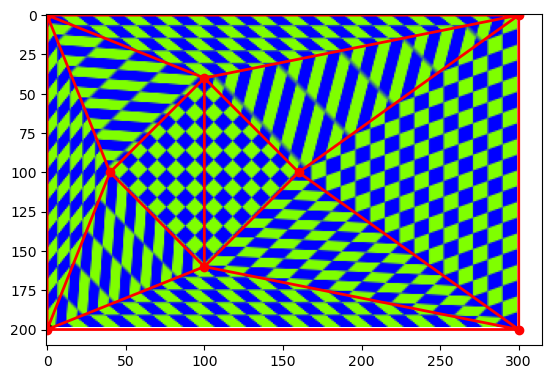

<Figure size 298x198 with 0 Axes>

In [11]:
#make a color checkerboard image
(xx,yy) = np.mgrid[1:200,1:300]
G = np.mod(np.floor(xx/10)+np.floor(yy/10),2)
B = np.mod(np.floor(xx/10)+np.floor(yy/10)+1,2)
image = np.stack((0.5*G,G,B),axis=2)

#coordinates of the image corners
pts_corners = np.array([[0,300,300,0],[0,0,200,200]])

#points on a square in the middle + image corners
pts_source = np.array([[50,150,150,50],[50,50,150,150]])
pts_source = np.concatenate((pts_source,pts_corners),axis=1)

#points on a diamond in the middle + image corners
pts_target = np.array([[100,160,100,40],[40,100,160,100]])
pts_target = np.concatenate((pts_target,pts_corners),axis=1)

#compute triangulation using mid-point between source and
#target to get triangles that are good for both.
pts_mid = 0.5*(pts_target+pts_source)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# display initial image
plt.imshow(image)
plt.triplot(pts_source[0,:],pts_source[1,:],tri,color='r',linewidth=2)
plt.plot(pts_source[0,:],pts_source[1,:],'ro')
plt.show()

# display warped image
(warped,tindex) = warp(image,pts_source,pts_target,tri)
plt.imshow(warped)
plt.triplot(pts_target[0,:],pts_target[1,:],tri,color='r',linewidth=2)
plt.plot(pts_target[0,:],pts_target[1,:],'ro')
plt.show()

# display animated movie by warping to weighted averages 
# of pts_source and pts_target

#assemble an array of image frames
movie = []
for t in np.arange(0,1.0+0.1,0.1):
    pts_warp = (1-t)*pts_source+t*pts_target
    warped_image,tindex = warp(image,pts_source,pts_warp,tri)
    movie.append(warped_image)

#use display_movie function defined in a5utils.py to create an animation
HTML(display_movie(movie).to_jshtml())